# Libraries

In [2]:
from model import LID_simulation
import numpy as np
import matplotlib.pyplot as plt

# Atomic fraction

FileNotFoundError: ./results/data_W_ns_E0.00122MJ_Edt1.00000eV_eta2.00000.csv not found.

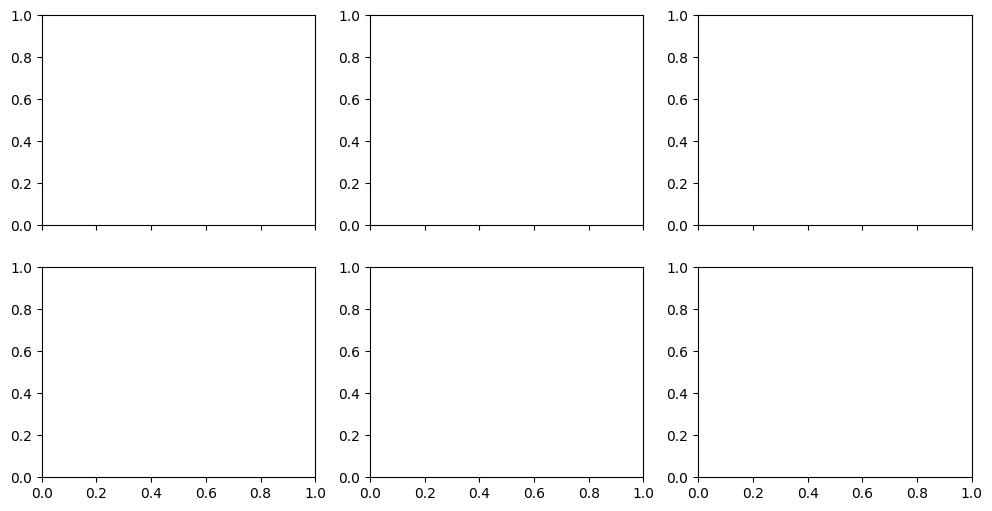

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12,6), sharex="col")

durations = ["ns", "us", "ms"]
titles = ["Наносекундный нагрев", "Микросекундный нагрев", "Миллисекундный нагрев"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.5, 2.0]
materials = ["W", "Be"]
phi = 1
eta_tr = 1e-2


for g, mat in enumerate(materials):
    for i in range(3):

        E = E_maxs[i] * np.linspace(0, 1, 26, endpoint=True)

        for k, E_dt in enumerate(E_dts):
            fa = np.zeros_like(E)
            Tmax = np.zeros_like(E)

            for j in range(3, 26):
                my_model = LID_simulation(E[j], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)

                filename = (
                    f"./results/data_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
                )
                results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")


                t = np.array(results[:, 0])
                cs = np.array(results[:, 1])
                T = np.array(results[:, 3])

                Jat = my_model.J_a(T, cs)
                Jmol = my_model.J_m(T, cs)
                J_des = Jat + Jmol

                N_a = np.trapz(Jat, x=t)
                N_des = np.trapz(J_des, x=t)

                if N_a < 1e12:
                    fa[j] = 0
                else:
                    fa[j] = N_a / N_des * 100

                Tmax[j] = T.max()
            
            axs[g][i].plot(Tmax, fa, label=fr"$E_{{\mathrm{{dt}}}}={E_dt}$ эВ")

            axs[g][i].set_xlabel(r"$T_s^{\mathrm{max}}$, K")
            axs[g][i].set_title(titles[i], fontsize=10)
            axs[g][i].set_xlim(500, 3500)
            axs[g][i].legend()

axs[0][0].set_ylabel(r"$f_a$, %")
plt.show()

# Analytics

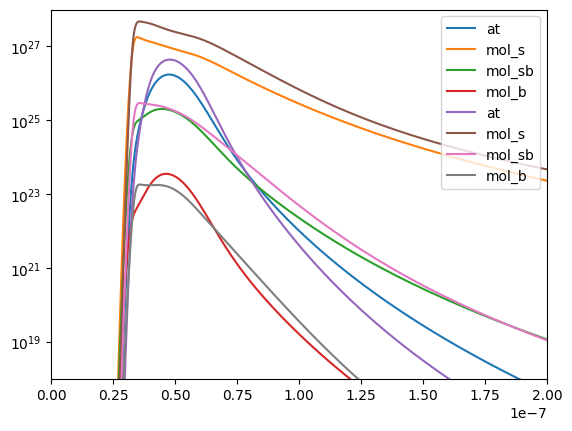

In [ ]:
from model import LID_simulation
import numpy as np
import matplotlib.pyplot as plt

N = 0
durations = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dt = 1.5
eta_tr = 1e-2
phi = 1
mat = "Be"

for mat in ["W", "Be"]:
    my_model = LID_simulation(E_maxs[N], durations[N], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)

    filename = (
        f"./results2/data_{mat}_{durations[N]}_E{E_maxs[N]/1e6:.3f}MJ_Edt{E_dt:.3f}eV_eta{-np.log10(eta_tr):.3f}.csv"
    )
    results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")



    t = np.array(results[:, 0])
    cs = np.array(results[:, 1])
    T = np.array(results[:, 3])
    cm = np.array(results[:, 4])

    Jat = my_model.J_a(T, cs)
    Jmol_s = my_model.J_m_s(T, cs)
    Jmol_sb = 2 * my_model.J_m_sb(T, cs, cm)
    Jmol_b = my_model.J_m_b(T, cm)


    plt.plot(t, Jat, label="at")
    plt.plot(t, Jmol_s, label="mol_s")
    plt.plot(t, Jmol_sb, label="mol_sb")
    plt.plot(t, Jmol_b, label="mol_b")

plt.yscale('log')
plt.legend()
plt.xlim(0, 200e-9)
plt.ylim(1e18, 1e28)
plt.show()